# Method 7 - Best Ideas High Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

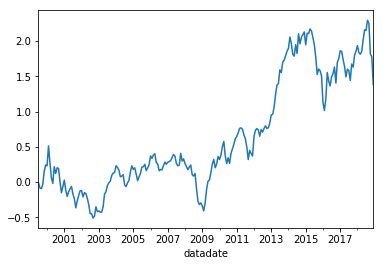

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.242427
2000-12-31   -0.245244
2001-12-31   -0.066407
2002-12-31   -0.338603
2003-12-31    0.959614
2004-12-31    0.083137
2005-12-31    0.014331
2006-12-31    0.003897
2007-12-31    0.060710
2008-12-31   -0.469491
2009-12-31    0.936179
2010-12-31    0.184181
2011-12-31   -0.151954
2012-12-31    0.340726
2013-12-31    0.555223
2014-12-31    0.096296
2015-12-31   -0.199148
2016-12-31    0.097734
2017-12-31    0.038541
2018-12-31   -0.166848
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     288.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.94e-88
Time:                        21:40:59   Log-Likelihood:                 465.35
No. Observations:                 234   AIC:                            -920.7
Df Residuals:                     229   BIC:                            -903.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.288      0.199      -0.002       0.007
mktrf          0.9816      0.062     15.720      0.000       0.859       1.105
me             0.7803      0.073     10.743      0.000       0.637       0.923
ia             0.1250      0.110      1.133      0.259      -0.092       0.343
roe           -0.8750      0.094     -9.260      0.000      -1.061      -0.689
==============================================================================
Omnibus:                       44.606   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.609
Skew:                           0.993   Prob(JB):                     3.13e-18
Kurtosis:                       5.080   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     366.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.03e-98
Time:                        21:40:59   Log-Likelihood:                 465.35
No. Observations:                 234   AIC:                            -920.7
Df Residuals:                     229   BIC:                            -903.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.236      0.216      -0.002       0.008
mktrf          0.9816      0.068     14.509      0.000       0.849       1.114
me             0.7803      0.081      9.626      0.000       0.621       0.939
ia             0.1250      0.133      0.938      0.348      -0.136       0.386
roe           -0.8750      0.142     -6.148      0.000      -1.154      -0.596
==============================================================================
Omnibus:                       44.606   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.609
Skew:                           0.993   Prob(JB):                     3.13e-18
Kurtosis:                       5.080   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     440.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.88e-106
Time:                        21:40:59   Log-Likelihood:                 465.35
No. Observations:                 234   AIC:                            -920.7
Df Residuals:                     229   BIC:                            -903.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.312      0.190      -0.001       0.007
mktrf          0.9816      0.065     15.000      0.000       0.853       1.110
me             0.7803      0.087      9.001      0.000       0.610       0.950
ia             0.1250      0.130      0.959      0.338      -0.131       0.381
roe           -0.8750      0.152     -5.771      0.000      -1.172      -0.578
==============================================================================
Omnibus:                       44.606   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.609
Skew:                           0.993   Prob(JB):                     3.13e-18
Kurtosis:                       5.080   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     218.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.72e-85
Time:                        21:40:59   Log-Likelihood:                 460.29
No. Observations:                 234   AIC:                            -908.6
Df Residuals:                     228   BIC:                            -887.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.646      0.519      -0.003       0.006
mktrf          1.1194      0.064     17.471      0.000       0.993       1.246
smb            0.8416      0.085      9.955      0.000       0.675       1.008
hml           -0.1268      0.100     -1.272      0.205      -0.323       0.070
rmw           -0.6695      0.113     -5.940      0.000      -0.892      -0.447
cma            0.3524      0.143      2.460      0.015       0.070       0.635
==============================================================================
Omnibus:                       49.188   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.010
Skew:                           1.046   Prob(JB):                     8.60e-22
Kurtosis:                       5.361   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     223.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.63e-86
Time:                        21:40:59   Log-Likelihood:                 460.29
No. Observations:                 234   AIC:                            -908.6
Df Residuals:                     228   BIC:                            -887.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.646      0.518      -0.003       0.006
mktrf          1.1194      0.063     17.726      0.000       0.996       1.243
smb            0.8416      0.069     12.124      0.000       0.706       0.978
hml           -0.1268      0.142     -0.892      0.373      -0.405       0.152
rmw           -0.6695      0.159     -4.204      0.000      -0.982      -0.357
cma            0.3524      0.190      1.858      0.063      -0.019       0.724
==============================================================================
Omnibus:                       49.188   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.010
Skew:                           1.046   Prob(JB):                     8.60e-22
Kurtosis:                       5.361   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     208.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.79e-83
Time:                        21:40:59   Log-Likelihood:                 460.29
No. Observations:                 234   AIC:                            -908.6
Df Residuals:                     228   BIC:                            -887.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.697      0.486      -0.003       0.006
mktrf          1.1194      0.067     16.622      0.000       0.987       1.251
smb            0.8416      0.070     12.000      0.000       0.704       0.979
hml           -0.1268      0.125     -1.016      0.310      -0.371       0.118
rmw           -0.6695      0.174     -3.841      0.000      -1.011      -0.328
cma            0.3524      0.170      2.067      0.039       0.018       0.686
==============================================================================
Omnibus:                       49.188   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.010
Skew:                           1.046   Prob(JB):                     8.60e-22
Kurtosis:                       5.361   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     242.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.95e-81
Time:                        21:40:59   Log-Likelihood:                 448.61
No. Observations:                 234   AIC:                            -887.2
Df Residuals:                     229   BIC:                            -870.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.089      0.929      -0.005       0.005
mktrf          1.1466      0.062     18.567      0.000       1.025       1.268
smb            1.1261      0.077     14.609      0.000       0.974       1.278
hml           -0.0499      0.077     -0.652      0.515      -0.201       0.101
umd           -0.2194      0.050     -4.367      0.000      -0.318      -0.120
==============================================================================
Omnibus:                       54.843   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.362
Skew:                           1.086   Prob(JB):                     2.21e-28
Kurtosis:                       5.889   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     230.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.05e-79
Time:                        21:40:59   Log-Likelihood:                 448.61
No. Observations:                 234   AIC:                            -887.2
Df Residuals:                     229   BIC:                            -870.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.089      0.929      -0.004       0.005
mktrf          1.1466      0.054     21.430      0.000       1.042       1.251
smb            1.1261      0.083     13.635      0.000       0.964       1.288
hml           -0.0499      0.115     -0.436      0.663      -0.275       0.175
umd           -0.2194      0.107     -2.058      0.040      -0.428      -0.010
==============================================================================
Omnibus:                       54.843   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.362
Skew:                           1.086   Prob(JB):                     2.21e-28
Kurtosis:                       5.889   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     192.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.16e-72
Time:                        21:40:59   Log-Likelihood:                 448.61
No. Observations:                 234   AIC:                            -887.2
Df Residuals:                     229   BIC:                            -870.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.096      0.923      -0.004       0.005
mktrf          1.1466      0.053     21.623      0.000       1.043       1.250
smb            1.1261      0.080     14.139      0.000       0.970       1.282
hml           -0.0499      0.106     -0.470      0.638      -0.258       0.158
umd           -0.2194      0.110     -1.995      0.046      -0.435      -0.004
==============================================================================
Omnibus:                       54.843   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.362
Skew:                           1.086   Prob(JB):                     2.21e-28
Kurtosis:                       5.889   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     162.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.37e-46
Time:                        21:40:59   Log-Likelihood:                 224.04
No. Observations:                 120   AIC:                            -438.1
Df Residuals:                     115   BIC:                            -424.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.306      0.194      -0.002       0.012
mktrf          1.0417      0.098     10.577      0.000       0.847       1.237
me             0.8233      0.097      8.463      0.000       0.631       1.016
ia             0.1221      0.152      0.802      0.424      -0.180       0.424
roe           -0.8089      0.135     -6.000      0.000      -1.076      -0.542
==============================================================================
Omnibus:                       16.094   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.678
Skew:                           0.815   Prob(JB):                     8.79e-05
Kurtosis:                       4.039   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     251.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.36e-56
Time:                        21:40:59   Log-Likelihood:                 224.04
No. Observations:                 120   AIC:                            -438.1
Df Residuals:                     115   BIC:                            -424.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.151      0.250      -0.003       0.013
mktrf          1.0417      0.122      8.546      0.000       0.803       1.281
me             0.8233      0.115      7.166      0.000       0.598       1.048
ia             0.1221      0.180      0.678      0.498      -0.231       0.475
roe           -0.8089      0.193     -4.194      0.000      -1.187      -0.431
==============================================================================
Omnibus:                       16.094   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.678
Skew:                           0.815   Prob(JB):                     8.79e-05
Kurtosis:                       4.039   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     338.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-62
Time:                        21:40:59   Log-Likelihood:                 224.04
No. Observations:                 120   AIC:                            -438.1
Df Residuals:                     115   BIC:                            -424.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.192      0.233      -0.003       0.013
mktrf          1.0417      0.119      8.773      0.000       0.809       1.274
me             0.8233      0.122      6.728      0.000       0.583       1.063
ia             0.1221      0.168      0.725      0.468      -0.208       0.452
roe           -0.8089      0.207     -3.916      0.000      -1.214      -0.404
==============================================================================
Omnibus:                       16.094   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.678
Skew:                           0.815   Prob(JB):                     8.79e-05
Kurtosis:                       4.039   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     140.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.67e-47
Time:                        21:41:00   Log-Likelihood:                 228.52
No. Observations:                 120   AIC:                            -445.0
Df Residuals:                     114   BIC:                            -428.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      1.224      0.223      -0.003       0.012
mktrf          1.2963      0.100     12.901      0.000       1.097       1.495
smb            0.9192      0.114      8.077      0.000       0.694       1.145
hml           -0.3024      0.139     -2.168      0.032      -0.579      -0.026
rmw           -0.4521      0.164     -2.749      0.007      -0.778      -0.126
cma            0.4955      0.180      2.750      0.007       0.139       0.852
==============================================================================
Omnibus:                       10.552   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.938
Skew:                           0.625   Prob(JB):                      0.00422
Kurtosis:                       3.791   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     211.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.00e-56
Time:                        21:41:00   Log-Likelihood:                 228.52
No. Observations:                 120   AIC:                            -445.0
Df Residuals:                     114   BIC:                            -428.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      1.158      0.247      -0.003       0.012
mktrf          1.2963      0.096     13.541      0.000       1.109       1.484
smb            0.9192      0.078     11.773      0.000       0.766       1.072
hml           -0.3024      0.179     -1.687      0.092      -0.654       0.049
rmw           -0.4521      0.210     -2.157      0.031      -0.863      -0.041
cma            0.4955      0.209      2.367      0.018       0.085       0.906
==============================================================================
Omnibus:                       10.552   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.938
Skew:                           0.625   Prob(JB):                      0.00422
Kurtosis:                       3.791   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     362.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.15e-68
Time:                        21:41:00   Log-Likelihood:                 228.52
No. Observations:                 120   AIC:                            -445.0
Df Residuals:                     114   BIC:                            -428.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      1.202      0.229      -0.003       0.012
mktrf          1.2963      0.093     13.879      0.000       1.113       1.479
smb            0.9192      0.075     12.292      0.000       0.773       1.066
hml           -0.3024      0.163     -1.850      0.064      -0.623       0.018
rmw           -0.4521      0.231     -1.956      0.050      -0.905       0.001
cma            0.4955      0.180      2.750      0.006       0.142       0.849
==============================================================================
Omnibus:                       10.552   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.938
Skew:                           0.625   Prob(JB):                      0.00422
Kurtosis:                       3.791   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     154.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.21e-45
Time:                        21:41:00   Log-Likelihood:                 221.31
No. Observations:                 120   AIC:                            -432.6
Df Residuals:                     115   BIC:                            -418.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.004      0.983      0.328      -0.004       0.011
mktrf          1.2563      0.089     14.154      0.000       1.080       1.432
smb            1.1413      0.101     11.294      0.000       0.941       1.341
hml           -0.0876      0.101     -0.866      0.388      -0.288       0.113
umd           -0.1731      0.062     -2.774      0.006      -0.297      -0.049
==============================================================================
Omnibus:                       21.386   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.404
Skew:                           0.920   Prob(JB):                     4.12e-07
Kurtosis:                       4.580   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     269.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.18e-57
Time:                        21:41:00   Log-Likelihood:                 221.31
No. Observations:                 120   AIC:                            -432.6
Df Residuals:                     115   BIC:                            -418.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.004      0.984      0.325      -0.004       0.011
mktrf          1.2563      0.073     17.170      0.000       1.113       1.400
smb            1.1413      0.104     10.940      0.000       0.937       1.346
hml           -0.0876      0.162     -0.540      0.589      -0.406       0.230
umd           -0.1731      0.120     -1.441      0.149      -0.408       0.062
==============================================================================
Omnibus:                       21.386   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.404
Skew:                           0.920   Prob(JB):                     4.12e-07
Kurtosis:                       4.580   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     350.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.02e-63
Time:                        21:41:00   Log-Likelihood:                 221.31
No. Observations:                 120   AIC:                            -432.6
Df Residuals:                     115   BIC:                            -418.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.003      1.083      0.279      -0.003       0.010
mktrf          1.2563      0.059     21.229      0.000       1.140       1.372
smb            1.1413      0.104     10.964      0.000       0.937       1.345
hml           -0.0876      0.159     -0.551      0.582      -0.400       0.224
umd           -0.1731      0.119     -1.454      0.146      -0.406       0.060
==============================================================================
Omnibus:                       21.386   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.404
Skew:                           0.920   Prob(JB):                     4.12e-07
Kurtosis:                       4.580   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     110.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.13e-37
Time:                        21:41:00   Log-Likelihood:                 248.46
No. Observations:                 114   AIC:                            -486.9
Df Residuals:                     109   BIC:                            -473.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.003      0.314      0.754      -0.005       0.006
mktrf          0.9667      0.082     11.749      0.000       0.804       1.130
me             0.6400      0.127      5.038      0.000       0.388       0.892
ia             0.1400      0.176      0.795      0.429      -0.209       0.489
roe           -0.9620      0.155     -6.213      0.000      -1.269      -0.655
==============================================================================
Omnibus:                       39.922   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.898
Skew:                           1.293   Prob(JB):                     6.13e-24
Kurtosis:                       6.977   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     178.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.19e-47
Time:                        21:41:00   Log-Likelihood:                 248.46
No. Observations:                 114   AIC:                            -486.9
Df Residuals:                     109   BIC:                            -473.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.404      0.686      -0.003       0.005
mktrf          0.9667      0.064     15.069      0.000       0.841       1.092
me             0.6400      0.106      6.059      0.000       0.433       0.847
ia             0.1400      0.193      0.727      0.467      -0.237       0.518
roe           -0.9620      0.224     -4.293      0.000      -1.401      -0.523
==============================================================================
Omnibus:                       39.922   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.898
Skew:                           1.293   Prob(JB):                     6.13e-24
Kurtosis:                       6.977   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     351.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.79e-61
Time:                        21:41:00   Log-Likelihood:                 248.46
No. Observations:                 114   AIC:                            -486.9
Df Residuals:                     109   BIC:                            -473.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.406      0.685      -0.003       0.005
mktrf          0.9667      0.049     19.729      0.000       0.871       1.063
me             0.6400      0.108      5.942      0.000       0.429       0.851
ia             0.1400      0.212      0.661      0.509      -0.275       0.555
roe           -0.9620      0.218     -4.407      0.000      -1.390      -0.534
==============================================================================
Omnibus:                       39.922   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.898
Skew:                           1.293   Prob(JB):                     6.13e-24
Kurtosis:                       6.977   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     72.48
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.55e-33
Time:                        21:41:00   Log-Likelihood:                 240.05
No. Observations:                 114   AIC:                            -468.1
Df Residuals:                     108   BIC:                            -451.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.003     -0.469      0.640      -0.007       0.005
mktrf          1.0220      0.085     12.041      0.000       0.854       1.190
smb            0.7159      0.138      5.195      0.000       0.443       0.989
hml            0.1055      0.176      0.600      0.549      -0.243       0.454
rmw           -0.7421      0.215     -3.449      0.001      -1.169      -0.316
cma            0.1193      0.273      0.437      0.663      -0.422       0.661
==============================================================================
Omnibus:                       48.524   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.122
Skew:                           1.477   Prob(JB):                     3.11e-37
Kurtosis:                       8.164   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     116.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.30e-42
Time:                        21:41:00   Log-Likelihood:                 240.05
No. Observations:                 114   AIC:                            -468.1
Df Residuals:                     108   BIC:                            -451.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.003     -0.562      0.574      -0.006       0.004
mktrf          1.0220      0.065     15.776      0.000       0.895       1.149
smb            0.7159      0.114      6.303      0.000       0.493       0.938
hml            0.1055      0.092      1.152      0.249      -0.074       0.285
rmw           -0.7421      0.278     -2.667      0.008      -1.287      -0.197
cma            0.1193      0.219      0.546      0.585      -0.309       0.548
==============================================================================
Omnibus:                       48.524   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.122
Skew:                           1.477   Prob(JB):                     3.11e-37
Kurtosis:                       8.164   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     145.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.07e-46
Time:                        21:41:00   Log-Likelihood:                 240.05
No. Observations:                 114   AIC:                            -468.1
Df Residuals:                     108   BIC:                            -451.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.585      0.558      -0.006       0.003
mktrf          1.0220      0.065     15.768      0.000       0.895       1.149
smb            0.7159      0.127      5.623      0.000       0.466       0.965
hml            0.1055      0.087      1.214      0.225      -0.065       0.276
rmw           -0.7421      0.281     -2.644      0.008      -1.292      -0.192
cma            0.1193      0.260      0.458      0.647      -0.391       0.630
==============================================================================
Omnibus:                       48.524   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.122
Skew:                           1.477   Prob(JB):                     3.11e-37
Kurtosis:                       8.164   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     85.68
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.49e-33
Time:                        21:41:00   Log-Likelihood:                 237.21
No. Observations:                 114   AIC:                            -464.4
Df Residuals:                     109   BIC:                            -450.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.552      0.582      -0.008       0.004
mktrf          1.0396      0.086     12.080      0.000       0.869       1.210
smb            0.8847      0.134      6.593      0.000       0.619       1.151
hml            0.1704      0.138      1.233      0.220      -0.104       0.444
umd           -0.2917      0.104     -2.798      0.006      -0.498      -0.085
==============================================================================
Omnibus:                       40.155   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.482
Skew:                           1.210   Prob(JB):                     4.64e-29
Kurtosis:                       7.649   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     171.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.79e-46
Time:                        21:41:00   Log-Likelihood:                 237.21
No. Observations:                 114   AIC:                            -464.4
Df Residuals:                     109   BIC:                            -450.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.595      0.552      -0.007       0.004
mktrf          1.0396      0.073     14.287      0.000       0.897       1.182
smb            0.8847      0.108      8.197      0.000       0.673       1.096
hml            0.1704      0.151      1.131      0.258      -0.125       0.466
umd           -0.2917      0.112     -2.609      0.009      -0.511      -0.073
==============================================================================
Omnibus:                       40.155   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.482
Skew:                           1.210   Prob(JB):                     4.64e-29
Kurtosis:                       7.649   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     226.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.95e-52
Time:                        21:41:00   Log-Likelihood:                 237.21
No. Observations:                 114   AIC:                            -464.4
Df Residuals:                     109   BIC:                            -450.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.568      0.570      -0.008       0.004
mktrf          1.0396      0.069     15.100      0.000       0.905       1.175
smb            0.8847      0.093      9.513      0.000       0.702       1.067
hml            0.1704      0.147      1.158      0.247      -0.118       0.459
umd           -0.2917      0.097     -3.004      0.003      -0.482      -0.101
==============================================================================
Omnibus:                       40.155   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.482
Skew:                           1.210   Prob(JB):                     4.64e-29
Kurtosis:                       7.649   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""